# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [2]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**
 The smart doen't move during simulation. It does not update its status
 Agent idled at green light with no oncoming traffic. so it is rewarded -5.25.
  
 Agent state not been updated. Then light turns red. 
 Agent properly idled at red light. So it is rewarded 1.97
 
 Again Agent state is not been updated. The light changes to green
 Agent doesn't move though there is no imcoming traffic . It is again -5.40
 

In [2]:
# %load smartcab/planner.py
import random

class RoutePlanner(object):
    """ Complex route planner that is meant for a perpendicular grid network. """

    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        self.destination = None

    def route_to(self, destination=None):
        """ Select the destination if one is provided, otherwise choose a random intersection. """

        self.destination = destination if destination is not None else random.choice(self.env.intersections.keys())

    def next_waypoint(self):
        """ Creates the next waypoint based on current heading, location,
            intended destination and L1 distance from destination. """

        # Collect global location details
        bounds = self.env.grid_size
        location = self.env.agent_states[self.agent]['location']
        heading = self.env.agent_states[self.agent]['heading']

        delta_a = (self.destination[0] - location[0], self.destination[1] - location[1])
        delta_b = (bounds[0] + delta_a[0] if delta_a[0] <= 0 else delta_a[0] - bounds[0], \
                   bounds[1] + delta_a[1] if delta_a[1] <= 0 else delta_a[1] - bounds[1])

        # Calculate true difference in location based on world-wrap
        # This will pre-determine the need for U-turns from improper headings
        dx = delta_a[0] if abs(delta_a[0]) < abs(delta_b[0]) else delta_b[0]
        dy = delta_a[1] if abs(delta_a[1]) < abs(delta_b[1]) else delta_b[1]

        # First check if destination is at location
        if dx == 0 and dy == 0:
            return None
        
        # Next check if destination is cardinally East or West of location    
        elif dx != 0:

            if dx * heading[0] > 0:  # Heading the correct East or West direction
                return 'forward'
            elif dx * heading[0] < 0 and heading[0] < 0: # Heading West, destination East
                if dy > 0: # Destination also to the South
                    return 'left'
                else:
                    return 'right'
            elif dx * heading[0] < 0 and heading[0] > 0: # Heading East, destination West
                if dy < 0: # Destination also to the North
                    return 'left'
                else:
                    return 'right'
            elif dx * heading[1] > 0: # Heading North destination West; Heading South destination East
                return 'left'
            else:
                return 'right'

        # Finally, check if destination is cardinally North or South of location
        elif dy != 0:

            if dy * heading[1] > 0:  # Heading the correct North or South direction
                return 'forward'
            elif dy * heading[1] < 0 and heading[1] < 0: # Heading North, destination South
                if dx < 0: # Destination also to the West
                    return 'left'
                else:
                    return 'right'
            elif dy * heading[1] < 0 and heading[1] > 0: # Heading South, destination North
                if dx > 0: # Destination also to the East
                    return 'left'
                else:
                    return 'right'
            elif dy * heading[0] > 0: # Heading West destination North; Heading East destination South
                return 'right'
            else:
                return 'left'

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

**Agent.py**
    Flags:
    
  **update_delay**: The contimueous time between time in seconds between actions
     Time between steps in each trial.
     
  **display**: This helps to enable or disable disable the GUI, if PyGame is enabled
    you may disable to the visual simulation (which can make the trials go faster) by setting the 'display' flag to False. 
    The default value of this flag is set to True.
    This flag enables the visual simulation 
    
  **log_metrics**: If you want to log trial and simulation results to log folder ( /logs) set the flag True or False accordingly.  to log the simluation results as a .csv file in /logs/.
   **optimized** :set to True to change the default log file name
   
**Environment.py**
   * When agent performs action, the function **act(self, agent, action)** is called.
       
**Simulator.py**
   * Render_text : This is the non-GUI render display of the simulation. Text based explanation is displayed.
   * Render : renders GUI that displays the action in simulation.
   
**Planner.py**
   * Considers EAST, WEST
    

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


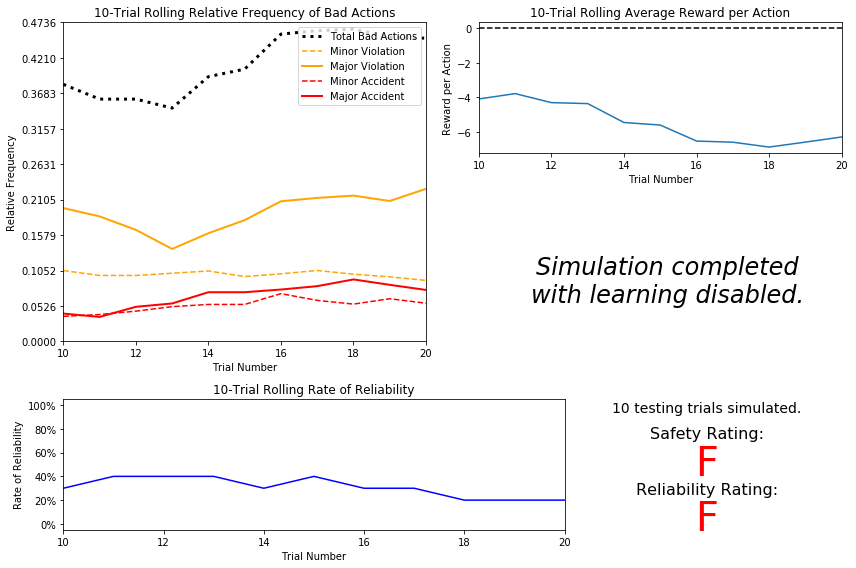

In [3]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*

- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

* Around 38% of the time , the driving agent took bad decisions.
* Around 5% of time it caused minor and major accidents and continued to increase to 9% for major accidents and to 8% on minor accidents.
 
* It has relaibility of 30% as the agent was driving randomly.  The relaibility doesn't make sense.

* The outcome doesn't change significantly. The relaibility is around 30%  and was receiving rewards -5 because of major accidents.
* As the number of trails, total bad decisions incresed from 38% to 45%, and total no of major valuations decreased from 20% to 14% for 13 trials and then increased to 22%.

* It is not considered as safe as 38% of the time it took bad decisions.
  It frequently gets into major or accidents it could endanger others.


-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate? Please note that whatever features you eventually choose for your agent's state, must be argued for here. That is: your code in agent.py should reflect the features chosen in this answer.
*

NOTE: You are not allowed to engineer new features for the smartcab. 

**Answer:**
  For Safety and effeciency , the following features are more important.
  * **state** = (waypoint, inputs['light'], inputs['oncoming'], inputs['left'])
  
  * **waypoint**: Provides  the direction the Smartcab should drive leading to the destination.
  * **Input** : provides signal state ( red or green) which is primary input to agent.
  
  The status of oncoming traffic. If the signal is green and agent waypoint is left, 
  it needs to consider if there is any oncoming traffic.  Left and right shows how traffic is moving. 
  If you have right signal and if there is an oncoming traffic(forward) from left, agent needs to consider that.
  
  * **Input- Right**: Having information that there is a car on the right doesn't help much. 
    where as for Left turn and for oncoming it is very essential to have clear information to avoid any problems.
   
* **deadline** : 
  Deadline is not a essential feature. Waypoint provides required information to reach destination.
  'Oncoming' and 'left' provides required information to go for left or forward . 
  So I felt deadline is not going add much value to the features.
  
  Another motivation to ignore deadline is to limit to the number of states (state space)
 

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

 state = (waypoint, inputs['light'], inputs['oncoming'], inputs['left'])
 Size of the space is combination of 4 states and its values.
 

 * waypoint    :   It has 3 values.    Left, Right, Forward
 * Inputs:light:   It has 2 values.    red, green
 * inputs:left :   This has 4 values:  None, forward, left, right.
 * inputs:oncoming:It has 4 values:    None, forward, left, right.
 
 **Total : 96 states**
 
 Yes Agent can learn from the states given.

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

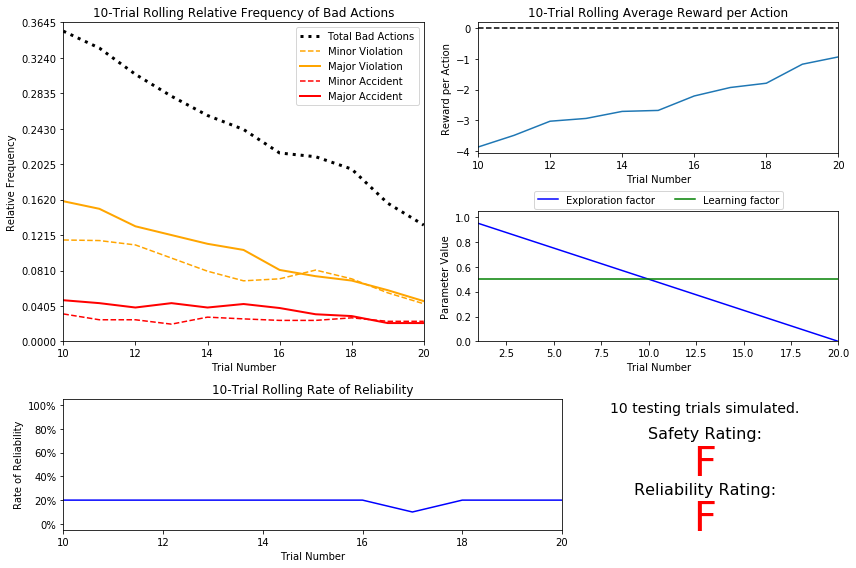

In [7]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**
**Similar observations between the basic driving agent and the default Q-Learning agent?**
 * During initial simulation,  5% of major accidents accured and its increased to 10% during trails and ended at 8%
   Minor accidents also followd similar pattern
   Major violation are at 20% and minor violations are at 10%
   Total bad decisions started at 37% and gradully increased during trails.
   
 * During default Q learning , major accidents happened at 5% of the time and reduced to 3% during trails .
   But minor accidents are almost stable at 3%.
   Major violation gradually recduced from 16% to 7% and minor violations reduced from 12% to 7%
   
   Overall default Q-learning strated learning and improoving better.
   
**Approximately how many training trials did the driving agent require before testing? 
Does that number make sense given the epsilon-tolerance?**

 There were 20 trails conducted before testing . Epsilon tolerance is set to decay by 0.05. So the number of trails set seems to be correct. 
 
**Is the decaying function you implemented for ϵ(the exploration factor) accurately represented in the parameters panel?**
  Yes the decaying function accurately represented in the parameters panel as shown below.
    parameters are :  {'a': 0.5, 'e': 0.4999999999999996} {'a': 0.5, 'e': 0.4499999999999996}

**As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?**

 The bad decisions reduced from 35% to 17% as trails are increased as shown in graph
 The bad decisions gradually decreased,
 
**•How does the safety and reliability rating compare to the initial driving agent?**

 Safety  and rating did not change . It has rating F for both.


-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

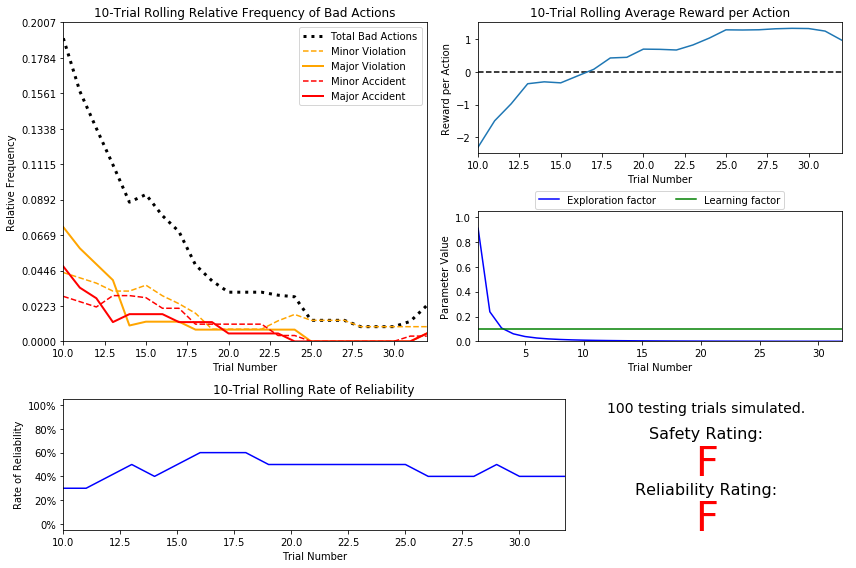

epsilon=1.0


In [68]:

# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')
print("epsilon=1.0")

In [62]:
 print("self.epsilon = math.fabs(math.cos(self.alpha*self.t))")


self.epsilon = math.fabs(math.cos(self.alpha*self.t))


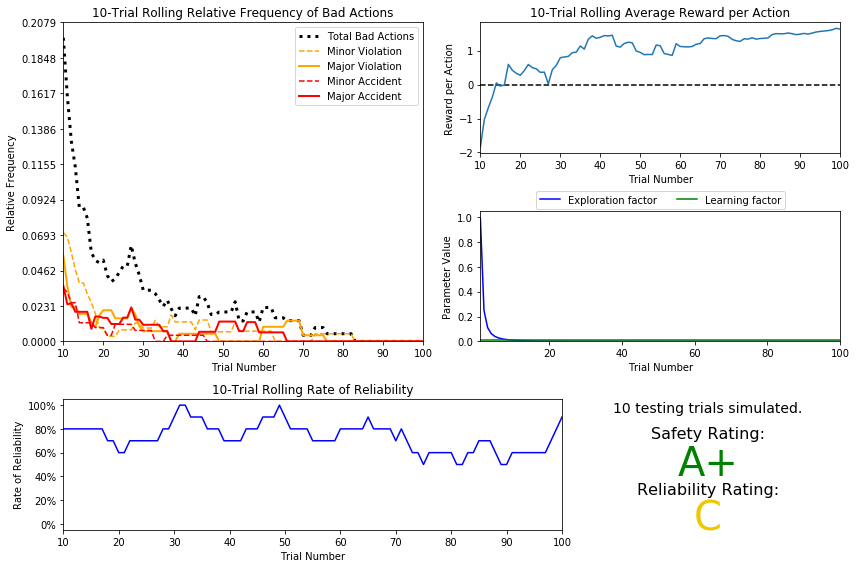

self.epsilon = 1.0/(self.t**2 + self.alpha*self.t) ,alpha=0.01, tolerance = 0.0001


In [66]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')
print ("self.epsilon = 1.0/(self.t**2 + self.alpha*self.t) ,alpha=0.01, tolerance = 0.0001")

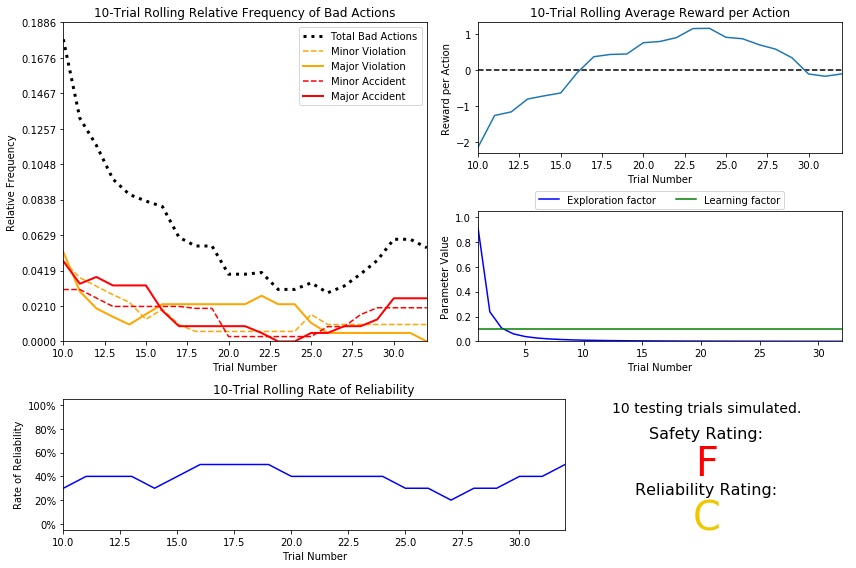

In [67]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

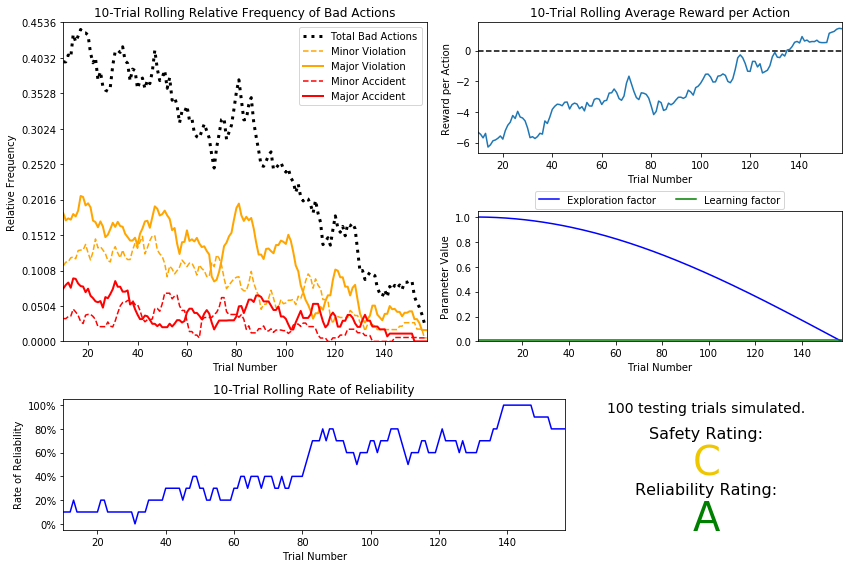

In [74]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

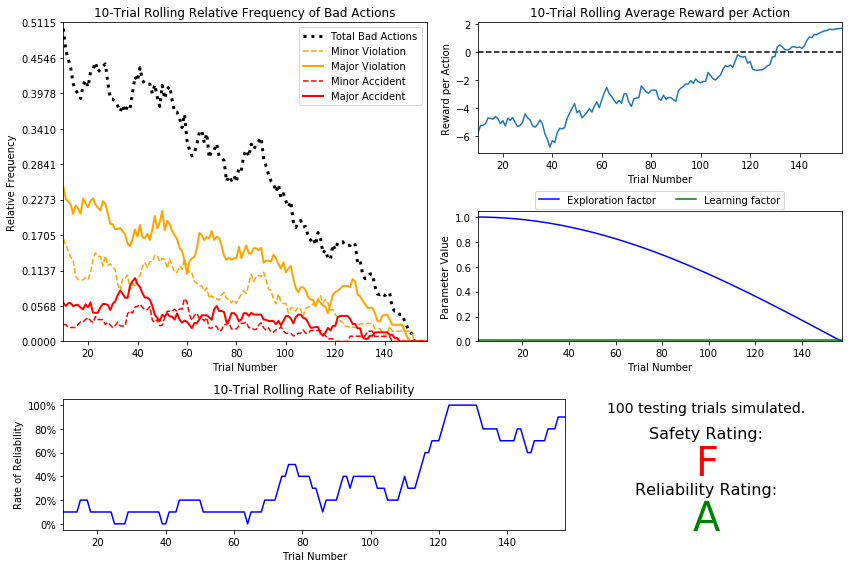

In [75]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

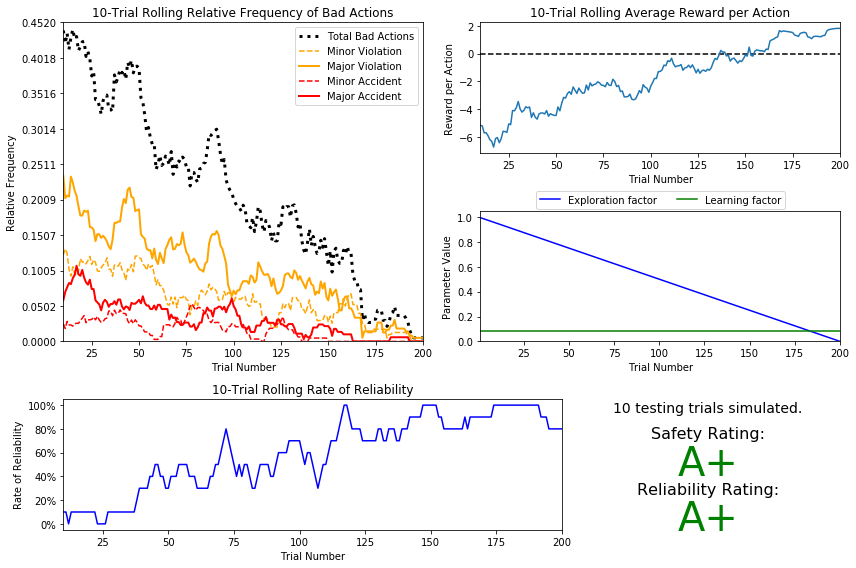

In [48]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

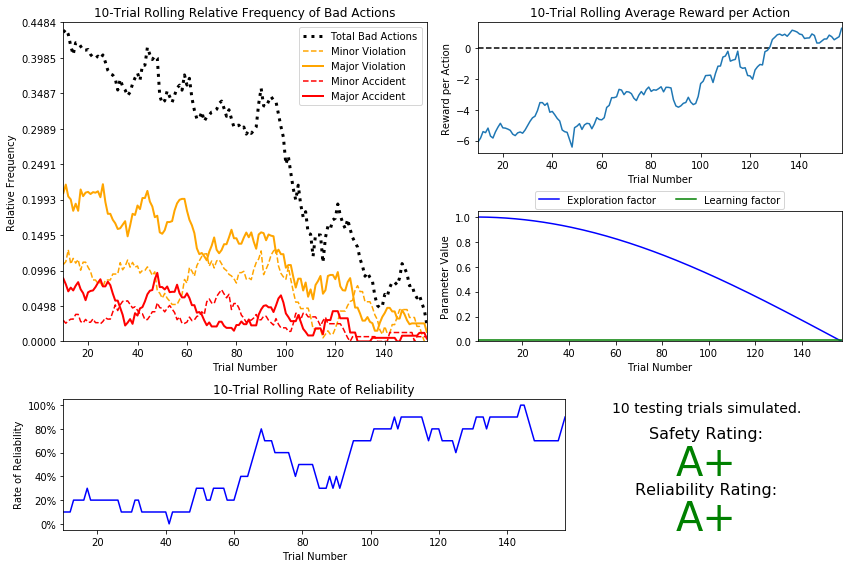

In [80]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**
  * I tried with various ways to optimize the learnig agent with many combinations of  epsilon, alpha and tolerance values. I tried with various exploration factors  and found ϵ=cos(at),for 0<a<1 working better.
  
  * I have made 200 trials during learning before beginning to test.
  
  * I used epsilon = 1.0 and changed the decay function to epsilon - 0.01 and the tolerance = 0.001. It has resulted in approximately 200 trials before testing. The learning rate, alpha = 0.01 after making various combinations as shown in plots. The agent start learning gradually.
  The exponential decay starts with a high epsilon which allows exploring new states and not getting stuck in a local minimum. The epsilon then decreases exponentially to minimize the random bahvior and thus allow for learning and correctly updating Q-table. As agent starts learning,the Q-table has become stable and accurate.
  
 * The final optimized Q-Learning agent's  has improved during trails and got rating as A+ in relaibility and safety.
  It has started with rating F for both safety and learning . 

* Yes I am statisfied with relaibility and safety ratings and believes that the agent learned from experience


### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8

1. Please summarize what the optimal policy is for the smartcab in the given environment. What would be the best set of instructions possible given what we know about the environment? 
   _You can explain with words or a table, but you should thoroughly discuss the optimal policy._

2. Next, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ 

3. Provide a few examples from your recorded Q-table which demonstrate that your smartcab learned the optimal policy. Explain why these entries demonstrate the optimal policy.

4. Try to find at least one entry where the smartcab did _not_ learn the optimal policy.  Discuss why your cab may have not learned the correct policy for the given state.

Be sure to document your `state` dictionary below, it should be easy for the reader to understand what each state represents.

**Answer:** :
**Summarize what the optimal policy**

  Using the states I defined optimal policies would be:
        state = (waypoint, inputs['light'], inputs['oncoming'], inputs['left'])
  When waypoint is right
   * when the light is red for the smartcab 
   * If there is car coming from left, the agent should wait.
   * Otherwise, go to right.
   * when the light is green for the smartcab it can always turn right.
  When waypoint is forward
   * If light is green, go forward
   * Otherwise, wait.
  When waypoint is left
   * If light is green, and oncoming traffic is moving left or no oncoming traffic, go left.
   * If light is red, wait.
   * Otherwise go forward.
     
**The policy we see from 'sim_improved-learning.txt' does follow the above optimum policy**  :

**Optimal Policy -1**

 ('left', 'green', 'left', None)
  + forward : 0.10
  + right : 0.12
  + None : -0.57
  + left : 0.51
        
The waypoint for agent is left, when the light is green and oncoming traffic is taking left turn or on no oncoming traffic , the agent can take left turn and has maximum reward of 0.51. It is a  optimum policy.

**Sub-Optimal Policy -2**

('right', 'green', 'forward', 'right')

  + forward : 0.05
  + right : 0.01
  + None : 0.00
  + left : 0.00
 
 The way point is right, when the light is green and there is a oncoming traffic and traffic is turning right.
 The agent can go forward (0.05) and also can take right, which has only 0.01. This is not exactly an optimum policy. 
 Though it doesn't create any problem, the agent still goes in incorrect direction. This is supposed to go right 
 as per waypoint , but agent goes forward. So it is a sub optimal policy.
 
**Optimal Policy -3**

('left', 'red', 'right', 'left')
 + forward : 0.00
 + right : 0.01
 + None : 0.04
 + left : 0.00
 
 The way point is left. When it is having red signal, it should stop. And this has highest reward (0.04). This is also an optimal policy.

**Optimal Policy -4**

('forward', 'red', 'right', None)
 + forward : -0.32
 + right : 0.02
 + None : 0.24
 + left : -1.59
 
 The way point is forward , but the signal is red. It should stop at signal , it gets rewarded with 0.24 . It is an optimal policy.

**Optimal Policy -5**

('right', 'green', 'right', 'forward')
 + forward : 0.00
 + right : 0.01
 + None : -0.04
 + left : -0.20
 
 The waypoint for agent is right , when there is a green signal, the other traffic will have red signal. 
 The agent can take right turn safely . The right turn has reward of 0.01 . 
 
**Sub-Optimal Policy -5**
 
 ('right', 'red', 'right', 'left')
 + forward : 0.00
 + right : 0.00
 + None : 0.00
 + left : 0.00
 
 The waypoint is 'right' for agent, when there is a red signal. The oncoming traffic is turning right and thetraffic on my left is going to Left. The Agent can safely turn to 'right'. But the reward is zero for every action, this might promt agent to take any random action. The agent hasn't learned yet, because it might not have visited this state yet. This is not a optimal policy.

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

Since there is no specified destination and keeps changing every time , there is no use of having future rewards.
The destination keeps changing after each trial. If we attempted to propagate reward away from the goal, we would eventually propagate reward away from every intersection.

For the environment, the states at each step are mostly independent. This does not effect the state of the light or traffic. Since waypoint decides the driving agent's next move there is no reason in rewarding the smartcab with future rewards since it is going to make anyway. Agent also doesn't have full view of entire grid and destination also keeps changing . In this context, the furure rewards will not help. 


 

 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.